In [9]:
from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields
import sys
sys.path.insert(0, 'Light/'); sys.path.insert(0, 'Building/')
from Light import Epsilon_ExpClass #For optical response with the pygdm package 
from pyGDM2 import core
from pyGDM2 import propagators
from pyGDM2 import tools
from pyGDM2 import linear
from pyGDM2 import visu

import numpy as np
import matplotlib.pyplot as plt
from ase.io import write,read

In [13]:
Strut = read("Ag_344.xyz")
ele = Strut.get_chemical_symbols()
Ele = list(set(ele))
Strut.positions -= Strut.get_center_of_mass()
xyz = Strut.positions
g = xyz
m = len(g)*[getattr(Epsilon_ExpClass, Ele[0])()]
Struct = structures.struct(2.88, g, m)

structure initialization - automatic mesh detection: hex
structure initialization - consistency check: 344/344 dipoles valid


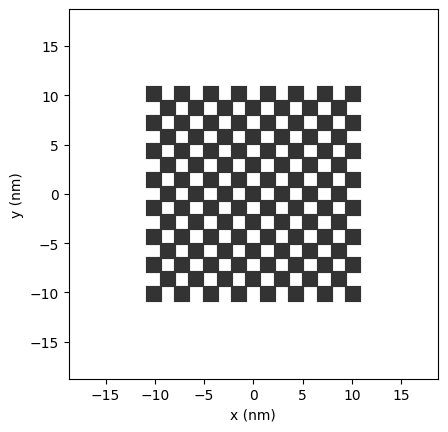

In [35]:
field_generator = fields.plane_wave
wavelengths = [400]
kwargs = dict(inc_angle=180, E_s=1, E_p=1, phase_Es=[-np.pi/2, np.pi/2])    # LCP, RCP
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)

dyads = propagators.DyadsQuasistatic123(n1=1)
sim = core.simulation(Struct, efield, dyads)

visu.structure(sim, projection="xy")

In [36]:
sim.scatter()


timing for wl=400.00nm - setup: EE 5121.8ms, inv.: 307.5ms, repropa.: 51.7ms (2 field configs), tot: 5481.9ms


1

In [37]:
field_kwargs = tools.get_possible_field_params_spectra(sim)
for i, conf in enumerate(field_kwargs):
    print("config", i, ":", conf)

config 0 : {'E_p': 1, 'E_s': 1, 'inc_angle': 180, 'phase_Es': -1.5707963267948966}
config 1 : {'E_p': 1, 'E_s': 1, 'inc_angle': 180, 'phase_Es': 1.5707963267948966}


In [38]:
search_dict = dict(wavelength=400)
idx = tools.get_closest_field_index(sim, search_dict)

print('closest match: index', idx)
print('    --> dict:', sim.E[idx][0])

closest match: index 0
    --> dict: {'E_p': 1, 'E_s': 1, 'inc_angle': 180, 'phase_Es': -1.5707963267948966, 'wavelength': 400}


In [39]:
a_ext, a_scat, a_abs = linear.extinct(sim, idx)
print("cross sections:")
print("    extinction = {:.2f} nm^2".format(float(a_ext)))
print("    scattering = {:.2f} nm^2".format(float(a_scat)))
print("    absorption = {:.2f} nm^2".format(float(a_abs)))

cross sections:
    extinction = 2979.66 nm^2
    scattering = 166.90 nm^2
    absorption = 2812.75 nm^2


In [40]:
config_idx = 0
wl, spectrum = tools.calculate_spectrum(sim,
                    field_kwargs[config_idx], linear.extinct)

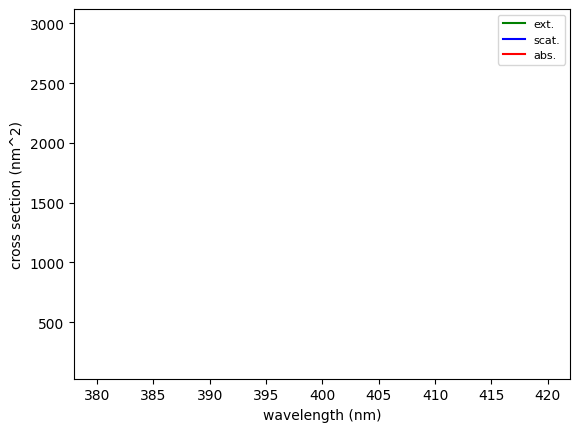

In [41]:
plt.plot(wl, spectrum.T[0], 'g-', label='ext.')
plt.plot(wl, spectrum.T[1], 'b-', label='scat.')
plt.plot(wl, spectrum.T[2], 'r-', label='abs.')

plt.xlabel("wavelength (nm)")
plt.ylabel("cross section (nm^2)")
plt.legend(loc='best', fontsize=8)

plt.show()

In [49]:
projection = 'XZ'
r_probe = tools.generate_NF_map(-500,500,30, -400,600,30,0, projection=projection)
NF = field_generator(r_probe, {}, 400,
                     inc_angle=45, E_s=0, E_p=1)

ValueError: `env_dict` must contain ['eps1', 'eps2', 'eps3', 'spacing']

NameError: name 'NF' is not defined

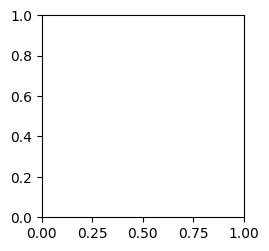

In [45]:
def plot_layer():
    plt.axhline(0, color='w',lw=1); plt.axhline(0, dashes=[2,2], color='k',lw=1)
    plt.axhspan(0,spacing, color='k', ls='--', fc='orange', alpha=0.35)
    plt.axhline(spacing, color='w',lw=1); plt.axhline(spacing, dashes=[2,2], color='k',lw=1)
    plt.arrow(350, -350, -150, 150, head_width=50, head_length=80, fc='k', ec='k')




plt.figure(figsize=(12,5))
plt.subplot(141, aspect='equal')
v = visu.vectorfield(NF, r_probe, complex_part='real', projection=projection, tit=projection+' real part', show=0)
plot_layer()

plt.subplot(142, aspect='equal')
v = visu.vectorfield(NF, r_probe, complex_part='imag', cmap=plt.cm.Reds, projection=projection, tit=projection+' imag part',  show=0)
plot_layer()


plt.subplot(243, aspect='equal')
v = visu.vectorfield_color(NF, r_probe, projection=projection, tit='intensity: '+r'$|E|^2/|E0|^2$', show=0)
plt.colorbar(v)
plt.xticks([]); plt.yticks([])
plot_layer()

plt.subplot(244, aspect='equal')
v = visu.vectorfield_color(NF, r_probe, projection=projection, fieldComp='ex', tit='Ex', show=0)
plt.colorbar(v)
plt.xticks([]); plt.yticks([])
plot_layer()

plt.subplot(247, aspect='equal')
v = visu.vectorfield_color(NF, r_probe, projection=projection, fieldComp='ey', tit='Ey', show=0)
plt.colorbar(v)
plt.xticks([]); plt.yticks([])
plot_layer()

plt.subplot(248, aspect='equal')
v = visu.vectorfield_color(NF, r_probe, projection=projection, fieldComp='ez', tit='Ez', show=0)
plt.colorbar(v)
plt.xticks([]); plt.yticks([])
plot_layer()

plt.show()